# Check lib versions

In [1]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [2]:
# !pip install -q --upgrade wandb


# import os
# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"
# import wandb
# wandb.login()

# wandb.__version__

In [3]:
# import wandb
# import os

# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"

# wandb.init(project="animaltracking", entity="mjirik")

In [4]:
# Some basic setup
import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import requests
import json

def unzip(input_file:Path, output_dir=None):
    from zipfile import ZipFile
    with ZipFile(input_file,"r") as zip_ref:
         for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
              zip_ref.extract(member=file, path=output_dir)
            
def classes_from_coco(annotation_file:Path):
    with open(annotation_file) as f:
        ann = json.load(f)
    _, cfg_classes = zip(*sorted([(cat["id"], cat["name"]) for cat in ann["categories"]]))
    return cfg_classes

def mywget(url, fname, force=False):
    fname = Path(fname)
    if fname.exists() and ~force:
        print(f"File already exists. Use force=True to owerwrite.")
        return
    fname.parent.mkdir(parents=True, exist_ok=True)
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
    

2023-02-23 09:13:20,176 - general_logger - DEBUG - mmdet.version=2.25.0


1.12.0a0+8a1a93a True


2023-02-23 09:13:20,557 - general_logger - DEBUG - 11.7
2023-02-23 09:13:20,559 - general_logger - DEBUG - GCC 9.4


NOTE! Installing ujson may make loading annotations faster.


In [5]:
mmdet.__version__

'2.25.0'

# Prepare data

Download and copy dataset to scratch dir.

In [29]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

local_input_data_dir = Path(scratchdir) / "data/orig/" # original data directory
local_output_data_dir = Path(scratchdir) / "data/processed/" # processed data directory

LOCAL_INPUT_DATA_DIR = str(local_input_data_dir)
LOCAL_OUTPUT_DATA_DIR = str(local_output_data_dir)

!echo "$LOCAL_INPUT_DATA_DIR"
!echo "$LOCAL_OUTPUT_DATA_DIR"

/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig
/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/processed


In [30]:
!pwd # print working directory

/auto/plzen1/home/jburian/projects/MMDetection_cell_nuclei


In [40]:
!mkdir -p "$LOCAL_INPUT_DATA_DIR"

# 1) copy data from your location or ...
!cp -r ~/data/biomedical/orig/cell_nuclei_COCO.zip "$SCRATCHDIR"/data.zip
# to see progressbar we use 'rsync -ah  instead of cp
# !rsync --progress -ah -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigleg_holder.zip "$SCRATCHDIR"/data.zip

# ... or download from internet
# mywget("https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip", scratchdir/"data.zip")
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip -O "$SCRATCHDIR"/data.zip

# 2) unzip
# !unzip -o "$SCRATCHDIR"/data.zip -d "$LOCAL_INPUT_DATA_DIR" > /dev/null
unzip(scratchdir/"data.zip", local_input_data_dir)

!ls "$LOCAL_INPUT_DATA_DIR"

100%|██████████| 31/31 [00:00<00:00, 4696.53it/s]

COCO_dataset  images  trainval.json


In [41]:
# Checking directories 
!echo "$SCRATCHDIR"
!ls "$SCRATCHDIR"
!ls "$SCRATCHDIR"/data/orig

/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz
checkpoints  data  data.zip
COCO_dataset  images  trainval.json


## Dataset paths

In [42]:
data_root = local_input_data_dir

# data_root = local_input_data_dir
img_prefix = './images'
train_ann_file = 'trainval.json'
val_ann_file  = 'trainval.json'
test_ann_file = 'trainval.json'

data_root

PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig')

### Train test val split

Run the following lines if you want split dataset. Change the dataset configuration in the `mmdetection` config : `cfg.train...`, `cfg.test...` and `cfg.val...`

In [43]:
# import coco_dataset
# fnin= data_root / 'trainval.json'
# fnin= data_root / 'annotations/instances_default.json'
# fn1 = data_root / 'train.json'
# fn2 = data_root / 'test.json'
# fn3 = data_root / 'val.json'
# fntmp = data_root / 'tmp.json'
# assert fnin.exists()
# ccd = coco_dataset.CocoDataset(fnin, data_root / "images")
# ccd.train_test_split(fn1, fntmp)
# ccd = coco_dataset.CocoDataset(fntmp, data_root / "images")
# ccd.train_test_split(fn2, fn3, 0.5)
# assert fn3.exists()

# train_ann_file = 'train.json'
# val_ann_file  = 'val.json'
# test_ann_file = 'test.json'


# Prepare pretrained checkpoint

In [44]:
mywget(
    "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth",
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)

File already exists. Use force=True to owerwrite.


In [ ]:
cfg_classes = classes_from_coco(data_root / train_ann_file)

mmdetection_path = Path(mmdet.__file__).parent.parent


logger.debug(f"outputdir={local_output_data_dir}")
logger.debug(f"input_data_dir={local_input_data_dir}")
logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
config = (
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py"
)
logger.debug(f"config.exists={config.exists()}")
# Setup a checkpoint file to load
checkpoint_pth = (
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)
logger.debug(f"checkpoint_pth.exists={checkpoint_pth.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, str(checkpoint_pth), map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint["meta"]["CLASSES"]

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

# Use the detector to do inference
img = mmdetection_path / "demo/demo.jpg"
result = inference_detector(model, img)
model.show_result(
    img, result, out_file=local_output_data_dir / "demo_output.jpg"
)  # save image with result


# My dataset training
cfg = Config.fromfile(
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py"
)

# Modify dataset type and path
cfg.dataset_type = "CocoDataset"
cfg.data_root = str(local_input_data_dir)

cfg.classes = cfg_classes


## Coco train, val and tes datasets definition
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = str(data_root)
cfg.data.test.ann_file = test_ann_file
# cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = img_prefix
cfg.data.test.classes = cfg.classes

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = str(data_root)
cfg.data.train.ann_file = train_ann_file
# cfg.data.test.ann_file = 'train.json'
cfg.data.train.img_prefix = img_prefix
cfg.data.train.classes = cfg.classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = str(data_root)
cfg.data.val.ann_file = val_ann_file
# cfg.data.test.ann_file = 'val.json'
cfg.data.val.img_prefix = img_prefix
cfg.data.val.classes = cfg.classes

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = len(cfg.classes)



# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = str(
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)

# Set up working dir to save files and logs.
cfg.work_dir = str(local_output_data_dir / "tutorial_exps")

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
# cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

def is_mlu_available():
    """Returns a bool indicating if MLU is currently available."""
    return hasattr(torch, 'is_mlu_available') and torch.is_mlu_available()


def get_device():
    """Returns an available device, cpu, cuda or mlu."""
    is_device_available = {
        'cuda': torch.cuda.is_available(),
        'mlu': is_mlu_available()
    }
    device_list = [k for k, v in is_device_available.items() if v]
    return device_list[0] if len(device_list) == 1 else 'cpu'

cfg.device = get_device()

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook"),
    dict(type='MMDetWandbHook',
    init_kwargs={'project': 'animaltracking'},
    interval=10,
    log_checkpoint=True,
    log_checkpoint_metadata=True,
    num_eval_images=3,
    bbox_score_thr=0.3)

]


# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}') # does not work for paths beginning '/' because of bug in lib2to3

logger.debug(f"cfg=\n{pformat(cfg)}")

# Build dataset
datasets = [build_dataset(cfg.data.train)]

logger.debug(f"classes={datasets[0].CLASSES}")

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)



2023-02-23 10:00:08,300 - general_logger - DEBUG - outputdir=/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/processed
2023-02-23 10:00:08,301 - general_logger - DEBUG - input_data_dir=/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig
2023-02-23 10:00:08,302 - general_logger - DEBUG - input_data_dir exists=True
2023-02-23 10:00:08,304 - general_logger - DEBUG - input_data_dir glob=[PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig/COCO_dataset'), PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig/images'), PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig/trainval.json'), PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig/COCO_dataset/images'), PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig/COCO_dataset/trainval.json'), PosixPath('/scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/data/orig/COCO_dataset

load checkpoint from local path: /scratch.ssd/jburian/job_14529059.meta-pbs.metacentrum.cz/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2023-02-23 10:00:49,027 - general_logger - DEBUG - cfg=
Config (path: /workspace/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py): {'model': {'type': 'FasterRCNN', 'backbone': {'type': 'ResNet', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': False}, 'norm_eval': True, 'style': 'caffe', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://detectron2/resnet50_caffe'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0],

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2023-02-23 10:00:49,368 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


# Try the detection

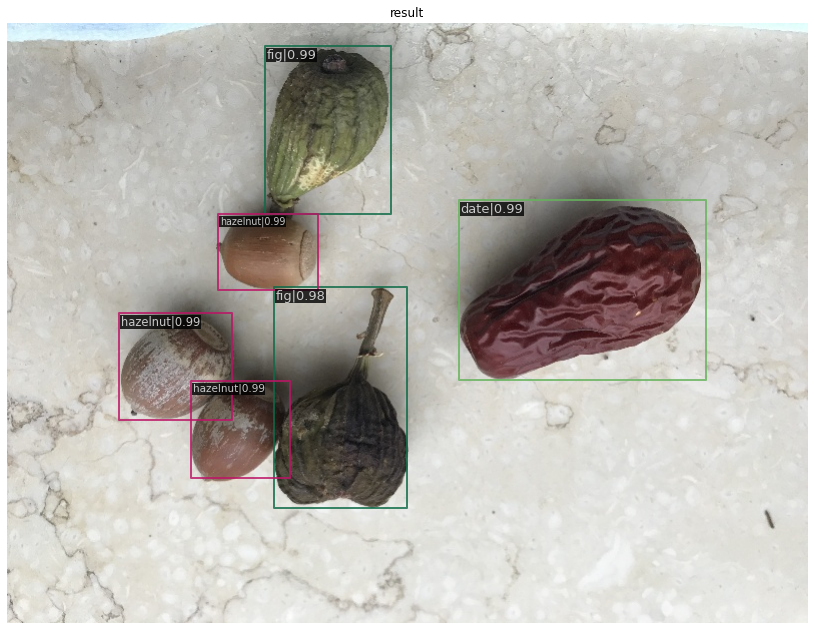

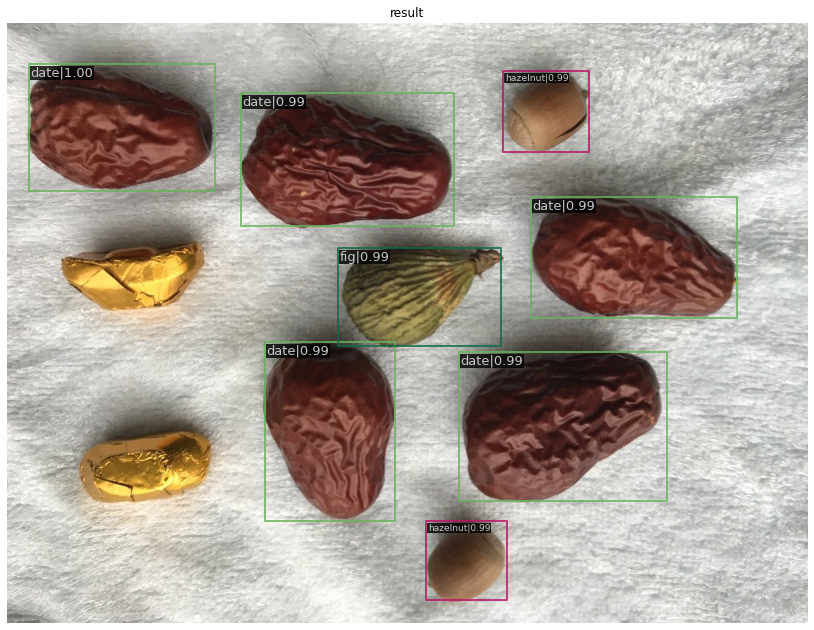

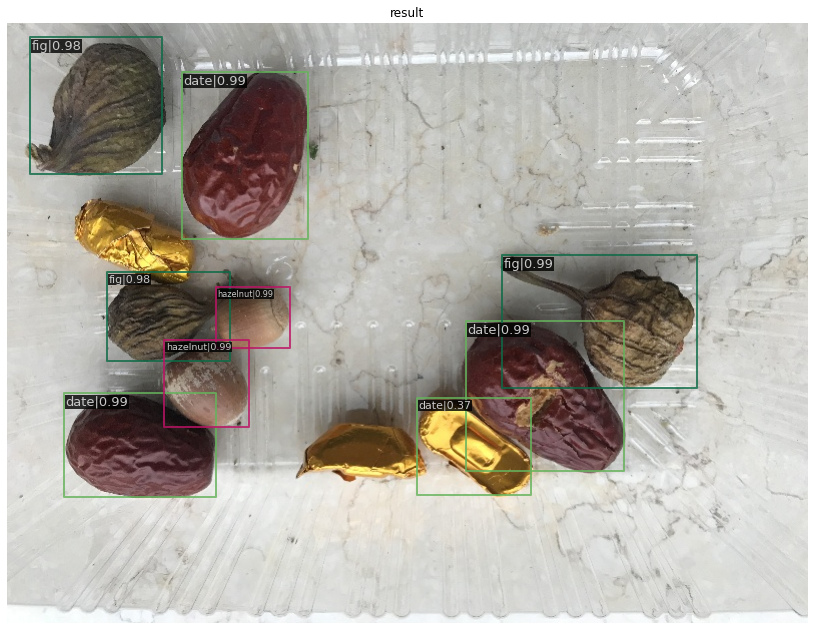

In [16]:
# path_test_images = local_input_data_dir /"images_test"
path_test_images = local_input_data_dir

filelist = list((path_test_images).glob("**/*.jpg"))
filelist.extend(list((path_test_images).glob("**/*.JPG")))
filelist.extend(list((path_test_images).glob("**/*.png")))
filelist.extend(list((path_test_images).glob("**/*.PNG")))


for img_fn in random.choices(filelist, k=3):

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img)
    show_result_pyplot(model, img, result)
    # save image with result 
    model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg")  

# Copy data to my home

In [17]:
dtstr = datetime.now().strftime("%Y%m%d_%H%M")
!mkdir -p ~/data/processed/$dtstr
!cp  -r "$SCRATCHDIR"/data/processed/* ~/data/processed/$dtstr
!ls ~/data/processed/$dtstr

In [20]:
%tensorboard --logdir /scratch/jburian/job_14521657.meta-pbs.metacentrum.cz/data/processed/tutorial_exps

UsageError: Line magic function `%tensorboard` not found.
